<a href="https://colab.research.google.com/github/julian1765/Project_2_Team_4/blob/main/LSTM_Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Initial Imports
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import regex as re
import nltk
nltk.download('stopwords')
%matplotlib inline

# Install twin and asyncio
!pip3 uninstall twint
!pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip install -qq whatthelang
!pip install nest_asyncio

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Uninstalling twint-2.1.21:
  Would remove:
    /root/.local/bin/twint
    /root/.local/lib/python3.6/site-packages/twint-2.1.21.dist-info/*
    /root/.local/lib/python3.6/site-packages/twint/*
Proceed (y/n)? y
  Successfully uninstalled twint-2.1.21
  Cloning https://github.com/twintproject/twint.git (to revision origin/master) to /tmp/pip-install-4xf9ag9b/twint
  Running command git clone -q https://github.com/twintproject/twint.git /tmp/pip-install-4xf9ag9b/twint
  Running command git checkout -q origin/master
  Created wheel for twint: filename=twint-2.1.21-cp36-none-any.whl size=38761 sha256=9b10eec7e90e6083d6ec646af9f8356d1ffac3e99ffdad14f0fbb26d143cf29e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ntftgd5p/wheels/4f/3b/75/62d04b3b446658ba85401e8868d3cd1d4bc22f17ad755460a6
Successfully built twint
  Consider adding this directory to PATH or, if you prefer to 

In [2]:
# Set the random seed for reproducibility
from numpy.random import seed
seed(1)

from tensorflow import random
random.set_seed(2)

In [3]:
# Data crawling using Twint
import twint
import nest_asyncio
nest_asyncio.apply()

import datetime

# Fetch data in a example data frame: 2020-04-14 00:00:00 to 2020-04-14 00:30:00

start_time='2020-01-01 00:00:00'

c = twint.Config()
c.Search = "tesla"
c.Lang="en"
c.Since= start_time
c.Limit = 5000
c.Pandas = True
c.Store_csv = True
c.Retries_count = 20
c.Hide_output = True
c.Custom["tweet"] = ["id", "date", "time", "tweet", "retweets_count", "likes_count"]
c.Resume = "./test.session"
c.Output = "./test.csv"
twint.run.Search(c)

In [4]:
# Load data
file_path = 'test.csv'
df = pd.read_csv(file_path)
df.head()

,id,date,time,tweet,retweets_count,likes_count
0,1350946555059195911,2021-01-17,23:22:12,@Marston4ca42 @Elmanogonsalves Competitor? I a...,0,0
1,1350946533122977792,2021-01-17,23:22:07,"Yo! Is it too late to buy the @Tesla truck,......",0,0
2,1350946522624647175,2021-01-17,23:22:05,$TSLA - Why doesn’t Tesla show 7 adults seated...,0,0
3,1350946510796705796,2021-01-17,23:22:02,Tesla Takes Legal Action Against Chinese News ...,0,0
4,1350946495751725065,2021-01-17,23:21:58,@TimJDillon Tim shitting on people who own Tes...,0,0


In [5]:
# Initialize dictionary to hold the compound, negative, neutral and positive scores for the tweets
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer 

analyzer = SentimentIntensityAnalyzer()
text_sent = {'Compound':[],
                 'Negative':[],
                 'Neutral':[],
                 'Positive':[]}
# Get sentiment from articles
for index, row in df.iterrows():
    try:
        text_sentiment = analyzer.polarity_scores(row["tweet"])
        text_sent["Compound"].append(text_sentiment["compound"])
        text_sent["Negative"].append(text_sentiment["neg"])
        text_sent["Neutral"].append(text_sentiment["neu"])
        text_sent["Positive"].append(text_sentiment["pos"])
        #text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass
# Add the newly created scores to the previously created bitcoin dataframe
text_sent_df = pd.DataFrame(text_sent)
test_sentiment = text_sent_df.join(df)
test_sentiment.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


,Compound,Negative,Neutral,Positive,id,date,time,tweet,retweets_count,likes_count
0,-0.5757,0.224,0.619,0.157,1350946555059195911,2021-01-17,23:22:12,@Marston4ca42 @Elmanogonsalves Competitor? I a...,0,0
1,0.0000,0.000,1.000,0.000,1350946533122977792,2021-01-17,23:22:07,"Yo! Is it too late to buy the @Tesla truck,......",0,0
2,-0.6739,0.171,0.829,0.000,1350946522624647175,2021-01-17,23:22:05,$TSLA - Why doesn’t Tesla show 7 adults seated...,0,0
3,0.1280,0.000,0.923,0.077,1350946510796705796,2021-01-17,23:22:02,Tesla Takes Legal Action Against Chinese News ...,0,0
4,-0.2349,0.157,0.748,0.094,1350946495751725065,2021-01-17,23:21:58,@TimJDillon Tim shitting on people who own Tes...,0,0


In [6]:
# Adding a Setiment Score to the Test DataFrame
test_sentiment['Sentiment_Score'] = np.nan
test_sentiment.loc[test_sentiment['Compound'] >= 0.05, 'Sentiment_Score'] = 1
test_sentiment.loc[test_sentiment['Compound'] <= - 0.05, 'Sentiment_Score'] = -1
test_sentiment.loc[(test_sentiment['Compound'] < 0.05) & (test_sentiment['Compound'] > -0.05), 'Sentiment_Score']= 0
test_sentiment.head()

,Compound,Negative,Neutral,Positive,id,date,time,tweet,retweets_count,likes_count,Sentiment_Score
0,-0.5757,0.224,0.619,0.157,1350946555059195911,2021-01-17,23:22:12,@Marston4ca42 @Elmanogonsalves Competitor? I a...,0,0,-1.0
1,0.0000,0.000,1.000,0.000,1350946533122977792,2021-01-17,23:22:07,"Yo! Is it too late to buy the @Tesla truck,......",0,0,0.0
2,-0.6739,0.171,0.829,0.000,1350946522624647175,2021-01-17,23:22:05,$TSLA - Why doesn’t Tesla show 7 adults seated...,0,0,-1.0
3,0.1280,0.000,0.923,0.077,1350946510796705796,2021-01-17,23:22:02,Tesla Takes Legal Action Against Chinese News ...,0,0,1.0
4,-0.2349,0.157,0.748,0.094,1350946495751725065,2021-01-17,23:21:58,@TimJDillon Tim shitting on people who own Tes...,0,0,-1.0


In [7]:
# Convert [-1, 0, 1] to [negative, neutral, and positive]

# Negative
test_sentiment.loc[test_sentiment['Sentiment_Score'] == -1, 'Sentiment_Score'] = 'Negative'

# Neutral

test_sentiment.loc[test_sentiment['Sentiment_Score'] == 0, 'Sentiment_Score'] = 'Neutral'

# Postive
test_sentiment.loc[test_sentiment['Sentiment_Score'] == 1, 'Sentiment_Score'] = 'Positive'

# View Into DataFrame
test_sentiment.tail()

,Compound,Negative,Neutral,Positive,id,date,time,tweet,retweets_count,likes_count,Sentiment_Score
4995,0.0000,0.0,1.000,0.000,1350860835376295939,2021-01-17,17:41:35,@Proxima06_Aiai @Tesla is about to go through ...,1,6,Neutral
4996,0.0000,0.0,1.000,0.000,1350860815184891908,2021-01-17,17:41:30,Tesla exterior preference. #tesla #tesla2021,1,4,Neutral
4997,0.8201,0.0,0.711,0.289,1350860796759212034,2021-01-17,17:41:26,@elonmusk hi sir I am happy that Tesla is in I...,0,0,Positive
4998,0.0000,0.0,1.000,0.000,1350860765519986688,2021-01-17,17:41:18,@moneycontrolcom @Tesla Thik thik laga lo bhai...,0,0,Neutral
4999,0.0000,0.0,1.000,0.000,1350860737162457089,2021-01-17,17:41:12,@SaraJAwesome @Tesla Is that a Nissan Sentra? ...,0,1,Neutral


In [8]:
# Clean the Text Function
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')


def clean_text(text):
  text = text.lower() # lowercase text
  text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
  text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
  text = text.replace('x', '')
 # text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
  return text

In [9]:
# Apply the clean text function above
test_sentiment['tweet'] = test_sentiment['tweet'].astype(str)
test_sentiment['tweet'] = test_sentiment['tweet'].apply(clean_text)
test_sentiment['tweet'] = test_sentiment['tweet'].str.replace('\d+', '')
test_sentiment.head()

,Compound,Negative,Neutral,Positive,id,date,time,tweet,retweets_count,likes_count,Sentiment_Score
0,-0.5757,0.224,0.619,0.157,1350946555059195911,2021-01-17,23:22:12,marstonca elmanogonsalves competitor i am al...,0,0,Negative
1,0.0000,0.000,1.000,0.000,1350946533122977792,2021-01-17,23:22:07,yo is it too late to buy the tesla truck i n...,0,0,Neutral
2,-0.6739,0.171,0.829,0.000,1350946522624647175,2021-01-17,23:22:05,tsla why doesnt tesla show adults seated in ...,0,0,Negative
3,0.1280,0.000,0.923,0.077,1350946510796705796,2021-01-17,23:22:02,tesla takes legal action against chinese news ...,0,0,Positive
4,-0.2349,0.157,0.748,0.094,1350946495751725065,2021-01-17,23:21:58,timjdillon tim shitting on people who own tes...,0,0,Negative


In [10]:
# Create the features set (X)
X = test_sentiment["tweet"].values

In [11]:
# Encode the Sentiment_Score
encoder = LabelEncoder()
encoder.fit(test_sentiment['Sentiment_Score'])
encoded_y = encoder.transform(test_sentiment['Sentiment_Score'])
dummy_y = tf.keras.utils.to_categorical(encoded_y)

Creating a LSTM Model to Perform Sentiment Analysis

In [12]:
# Import the Tokenizer method from Keras
from tensorflow.keras.preprocessing.text import Tokenizer

# Create an instance of the tokenizer
tokenizer = Tokenizer(lower=True)

In [13]:
# Fit to the X dataSet
tokenizer.fit_on_texts(X)

In [14]:
# Print the first five elements of the encoded vocabulary
for token in list(tokenizer.word_index)[:50]:
    print(f"word: '{token}', token: {tokenizer.word_index[token]}")

word: 'tesla', token: 1
word: 'the', token: 2
word: 'a', token: 3
word: 'to', token: 4
word: 'and', token: 5
word: 'i', token: 6
word: 'https', token: 7
word: 'tco', token: 8
word: 'is', token: 9
word: 'in', token: 10
word: 'of', token: 11
word: 'for', token: 12
word: 'elonmusk', token: 13
word: 'you', token: 14
word: 'it', token: 15
word: 'that', token: 16
word: 'this', token: 17
word: 'on', token: 18
word: 'with', token: 19
word: 'be', token: 20
word: 'are', token: 21
word: 'my', token: 22
word: 'but', token: 23
word: 'have', token: 24
word: 'not', token: 25
word: 'de', token: 26
word: 'they', token: 27
word: 'its', token: 28
word: 'will', token: 29
word: 'me', token: 30
word: 'at', token: 31
word: 'so', token: 32
word: 'if', token: 33
word: 'model', token: 34
word: 'like', token: 35
word: 'can', token: 36
word: 'just', token: 37
word: 'as', token: 38
word: 'car', token: 39
word: 'was', token: 40
word: 'no', token: 41
word: 'do', token: 42
word: 'or', token: 43
word: 'more', token: 4

In [15]:
# Transform the text data to numerical sequences
X_seq = tokenizer.texts_to_sequences(X)

In [16]:
# Import the pad_sequences method from Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
# Set the pad size
max_words = 200

# Pad the sequences using the pad_sequences() method
X_pad = pad_sequences(X_seq, maxlen=max_words, padding="post")

In [18]:
# Creating training, validation, and testing sets using the encoded data
from sklearn.model_selection import train_test_split
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_pad, dummy_y)

X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_rnn, y_train_rnn)

In [19]:
# Import Keras modules for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [20]:
# Model set-up
vocabulary_size = len(tokenizer.word_counts.keys()) + 1
embedding_size = 64

In [21]:
# Define Model
model = Sequential()

# Layer 1
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

# Layer 2 
model.add(LSTM(units=280))

# Output Layer
model.add(Dense(units=3, activation='sigmoid'))


In [22]:
#model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size, and output embedding dimension of size 64 we set at the top
 #   tf.keras.layers.Embedding(vocabulary_size, embedding_size),
   # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_size)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
  #  tf.keras.layers.Dense(embedding_size, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
   # tf.keras.layers.Dense(3, activation='softmax')
#])#

In [23]:
# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           1141056   
_________________________________________________________________
lstm (LSTM)                  (None, 280)               386400    
_________________________________________________________________
dense (Dense)                (None, 3)                 843       
Total params: 1,528,299
Trainable params: 1,528,299
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Fit the model
output = model.fit(X_train_rnn,y_train_rnn,epochs=10,batch_size=1000, validation_data=(X_val_rnn, y_val_rnn))

Epoch 1/10
3/3 [==============================] - 40s 12s/step - loss: 1.0867 - accuracy: 0.4036 - tp: 1938.2500 - tn: 938.2500 - fp: 3373.7500 - fn: 217.7500 - precision: 0.3604 - recall: 0.9157 - auc: 0.6111 - val_loss: 1.0450 - val_accuracy: 0.4478 - val_tp: 764.0000 - val_tn: 764.0000 - val_fp: 1112.0000 - val_fn: 174.0000 - val_precision: 0.4072 - val_recall: 0.8145 - val_auc: 0.6311
Epoch 2/10
3/3 [==============================] - 33s 11s/step - loss: 1.0501 - accuracy: 0.4344 - tp: 1747.5000 - tn: 1747.5000 - fp: 2564.5000 - fn: 408.5000 - precision: 0.4046 - recall: 0.8093 - auc: 0.6204 - val_loss: 1.0413 - val_accuracy: 0.4478 - val_tp: 764.0000 - val_tn: 764.0000 - val_fp: 1112.0000 - val_fn: 174.0000 - val_precision: 0.4072 - val_recall: 0.8145 - val_auc: 0.6311
Epoch 3/10
3/3 [==============================] - 38s 14s/step - loss: 1.0428 - accuracy: 0.4478 - tp: 1751.0000 - tn: 1751.0000 - fp: 2561.0000 - fn: 405.0000 - precision: 0.4067 - recall: 0.8134 - auc: 0.6316 - va

In [ ]:
y_rnn_pred = np.argmax(model.predict(X_test_rnn),axis=-1)

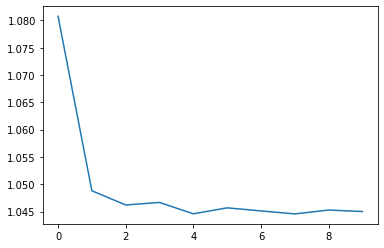

In [26]:
import matplotlib.pyplot as plt
plt.plot(output.history['loss'])

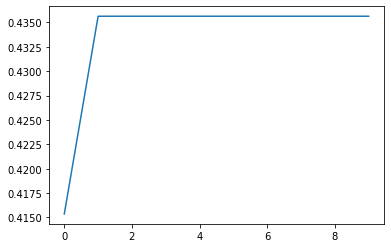

In [27]:
plt.plot(output.history['accuracy'])

In [28]:
# Save Model as JSON
nlp_json = model.to_json()

file_path = Path("model.json")
with open(file_path, "w") as json_file:
    json_file.write(nlp_json)

# Save weights
file_path = "model.h5"
model.save_weights("model.h5")